In [2]:
import numpy as np
from math import exp, log
import scipy.optimize as sp
import matplotlib.pyplot as plt
import scipy.io                      # To import .mat files
from scipy.special import expit      # Vectorized sigmoid function
import scipy.misc                    # Used to show matrix as an image
import matplotlib.cm as cm           # Used to display images in a specific colormap
import random                        # To pick random images to display
import itertools

# np.set_printoptions(threshold=np.inf)

# Visualise Data

def getImage(row):
    
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return np.transpose(square)

def displayImage(indicesToDisplay = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indicesToDisplay:
        indicesToDisplay = random.sample(range(X.shape[0]), nrows * ncols)
        
    bigPicture = np.zeros((height * nrows, width * ncols))
    
    irow, icol = 0, 0
    for idx in indicesToDisplay:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getImage(X[idx])
        bigPicture[irow * height: irow * height + iimg.shape[0], icol * width : icol * width + iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage(bigPicture)
    plt.imshow(img,cmap = cm.Greys_r)
    plt.show()
    
# Sigmoid Functions

def sigmoid (x):
    
    result = []
    size = np.shape(x)
    
    try:
        for i in x.flat:
            result.append((1 / (1 + exp(-i))))
        return np.reshape(result, size)
    except:
        return (1 / (1 + exp(-x)))
    
def sigmoidGradient(x):
    
    return sigmoid(x) * (1 - sigmoid(x))


def predict(thetaOne, thetaTwo, X):
    
    m = np.shape(X)[0]
    numberOfOutputLabels = np.shape(thetaTwo)[0]
    
    p = np.zeros((m, 1))
    
    # Column of ones already added to X | X = 5000 x 401 | thetaOne' = 401 x 25 | h1 = 5000 x 25
    h1 = sigmoid(np.dot(X, thetaOne.T))
    
    # Add column of ones to h1
    temp = np.ones((np.shape(h1)[0], 1))
    # h1 = np.hstack((temp, h1)) 
    h1 = np.append(temp, h1, axis = 1)
    
    # h1 = 5000 x 26 | thetaTwo' = 26 x 10 | h2 = 5000 x 10
    h2 = sigmoid(np.dot(h1, thetaTwo.T))
    
    # Get index of maximum element from each row
    p = np.argmax(h2, axis = 1)
    
    # p + 1 since data is 1 indexed instead of 0 indexed
    return p + 1
    
    

def forwardPropagation(nnParameters, inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda):
     
    # Unroll Parameters
    (thetaOne, thetaTwo) = reshapeParameters(nnParameters)
    
    # Number Of Examples
    m = np.shape(X)[0]
    
    # Transpose theta beccause reshapeParameters() returns transposed weights
    thetaOne = thetaOne.T
    thetaTwo = thetaTwo.T
    
    
    # ==============================================================================
    
    #                            FORWARD PROPAGATION    
    
    # ==============================================================================

    # Add column of ones to X and assign to a1
    # temp = np.ones((np.shape(X)[0], 1))
    # a1 = np.hstack((temp, a1))
    
    # Set a1 = X (X has column of ones)
    a1 = X

    # a1 = 5000 x 401 | thetaOne' = 401 x 25 | z2 = 5000 x 25 | a2 = 5000 x 25
    z2 = np.dot(a1, thetaOne.T)
    a2 = sigmoid(z2)
    
    
    # Add column of ones to a2 
    temp = np.ones((np.shape(a2)[0], 1))
    a2 = np.hstack((temp, a2))
    
    # a2 = 5000 x 26 | thetaTwo' = 26 x 10 | z3 = 5000 x 10 | a3 = 5000 x 10
    z3 = np.dot(a2, thetaTwo.T)
    a3 = sigmoid(z3)
    hypothesis = a3
    
            
    # Create yMatrix | yMatrix = 5000 x 10
    yMatrix = np.zeros((m, outputLayerSize))
    for i in range (np.shape(y)[0]):
        yMatrix[i, y[i] - 1] = 1
            
    # Unregularised Term 
    unregularisedTerm = -(1/m) * np.sum(yMatrix * np.log(hypothesis) + (1 - yMatrix) * np.log(1 - hypothesis))

    # Set first column on theta to zero
    thetaOne[:, 0] = 0
    thetaTwo[:, 0] = 0
    
    # Regularised Term
    regularisedTerm = (lmbda / (2*m)) * ( np.sum(np.square(thetaOne)) + np.sum(np.square(thetaTwo)) )
    
    return regularisedTerm + unregularisedTerm
    
    
def backPropagation(nnParameters, inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda):
    
    # Unroll Parameters
    (thetaOne, thetaTwo) = reshapeParameters(nnParameters)
    
    # Number Of Examples
    m = np.shape(X)[0]
    
    # Transpose theta beccause reshapeParameters() returns transposed weights
    thetaOne = thetaOne.T
    thetaTwo = thetaTwo.T
    
    # ==============================================================================
                                
    #                            BACKWARD PROPAGATION    

    # ==============================================================================

    a1 = X

    # a1 = 5000 x 401 | thetaOne' = 401 x 25 | z2 = 5000 x 25 | a2 = 5000 x 25
    z2 = np.dot(a1, thetaOne.T)
    a2 = sigmoid(z2)
    
    
    # Add column of ones to a2 
    temp = np.ones((np.shape(a2)[0], 1))
    a2 = np.hstack((temp, a2))
    
    # a2 = 5000 x 26 | thetaTwo' = 26 x 10 | z3 = 5000 x 10 | a3 = 5000 x 10
    z3 = np.dot(a2, thetaTwo.T)
    a3 = sigmoid(z3)
    
    # Create yMatrix | yMatrix = 5000 x 10
    yMatrix = np.zeros((m, outputLayerSize))
    for i in range (np.shape(y)[0]):
        yMatrix[i, y[i] - 1] = 1

    # d3 = 5000 x 10
    d3 = a3 - yMatrix
    
    
    # Do not include bias term in thetaTwo | thetaTwo = 10 x 26 | thetaTwoCopy = 10 x 25 | d3 = 5000 x 10 |d2 = 5000 x 25
    (unwanted, thetaTwoCopy) = np.hsplit(thetaTwo, (1, ))
    d2 = np.dot( d3, thetaTwoCopy ) * sigmoidGradient(z2)
    
    # deltaOne = 25 x 401 | d2' = 25 x 5000 | a1 = 5000 x 401
    deltaOne = np.dot(d2.T, a1)
    
    # deltaTwo = 10 x 26 | d3' = 10 x 5000 | a2 = 5000 x 26
    deltaTwo = np.dot(d3.T, a2)
    
    # Regularised Gradient
    thetaOne[:, 0] = 0
    thetaTwo[:, 0] = 0
    
    regularisedGradientTermOne = (lmbda / m) * thetaOne
    regularisedGradientTermTwo = (lmbda / m) * thetaTwo
    
    thetaOneGradient = ((1/m) * deltaOne) + regularisedGradientTermOne
    thetaTwoGradient = ((1/m) * deltaTwo) + regularisedGradientTermTwo
    
    
    # Unroll Gradients
    gradient = flattenParameters(thetaOneGradient.T, thetaTwoGradient.T)
    

    return gradient


def flattenParameters(parameterOne, parameterTwo):
    
    parameterOne = parameterOne.flatten()
    parameterTwo = parameterTwo.flatten()
    lenght = np.shape(parameterOne)[0] + np.shape(parameterTwo)[0]
    return np.array(np.hstack((parameterOne, parameterTwo))).reshape(lenght, 1)

def reshapeParameters(flattenedArray):
    
    # thetaOne = flattenedArray[:(inputLayerSize + 1) * hiddenLayerSize].reshape((hiddenLayerSize, inputLayerSize + 1))
    thetaOne = flattenedArray[:(inputLayerSize + 1) * hiddenLayerSize].reshape((inputLayerSize + 1, hiddenLayerSize))

    # thetaTwo = flattenedArray[(inputLayerSize +1) * hiddenLayerSize:].reshape((outputLayerSize, hiddenLayerSize + 1))
    thetaTwo = flattenedArray[(inputLayerSize +1) * hiddenLayerSize:].reshape((hiddenLayerSize + 1, outputLayerSize))
    
    return [thetaOne, thetaTwo]

# def flattenX(X):
#     return np.array(X.flatten()).reshape((m * (inputLayerSize + 1), 1))

# def reshapeX(flattenedX):
#     return np.array(flattenedX).reshape((m, inputLayerSize + 1))

def genRandomThetas():
    epsilonInit = 0.12
    thetaOneShape = (hiddenLayerSize, inputLayerSize + 1)
    thetaTwoShape = (outputLayerSize, hiddenLayerSize + 1)
    randomThetas = [np.random.rand(*thetaOneShape) * 2 * epsilonInit - epsilonInit, np.random.rand(*thetaTwoShape) * 2 * epsilonInit - epsilonInit
                   ]
    return randomThetas


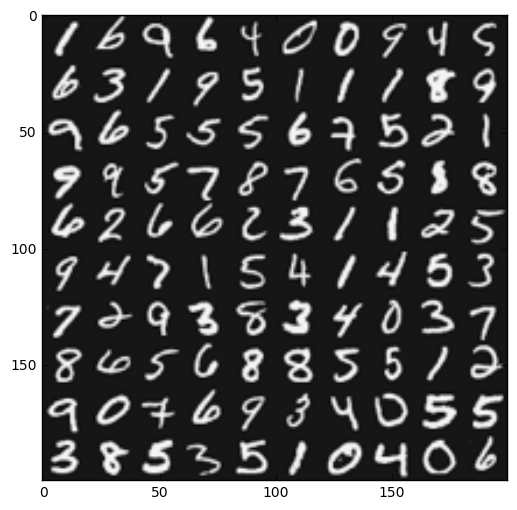

Loading Saved Neural Network Parameters...

Feed Forward Propagation...
Cost at loaded parameters without regularisation: 0.287629165161
Cost at loaded parameters with regularisation: 0.383769859091

Initialising Parameters...
         Current function value: 0.008843
         Iterations: 100
         Function evaluations: 297
         Gradient evaluations: 297


In [3]:
dataFile = '/Users/Zohair/Library/Mobile Documents/com~apple~CloudDocs/Education/Machine Learning/machine-learning-ex4/ex4/ex4data1.mat'
data = scipy.io.loadmat(dataFile)

# Get X & y
(X, y) = data['X'], data['y']

# Add Column Of Ones
m = np.shape(X)[0]
temp = np.ones((m, 1)) 
X = np.hstack((temp, X))
n = np.shape(X)[1]

# Display Data
displayImage()

# Use Saved Neural Net Parameters
print ("Loading Saved Neural Network Parameters...\n")
dataFile = '/Users/Zohair/Library/Mobile Documents/com~apple~CloudDocs/Education/Machine Learning/machine-learning-ex4/ex4/ex4weights.mat'
data = scipy.io.loadmat(dataFile)

# Get ThetaOne and ThetaTwo
(thetaOne, thetaTwo) = data['Theta1'], data['Theta2']
# Theta1 - 25 x 401
# Theta2 - 10 x 26

# Useful Variables
inputLayerSize = 400
hiddenLayerSize = 25
outputLayerSize = 10

print ("Feed Forward Propagation...")

lmbda = 0
cost = forwardPropagation(flattenParameters(thetaOne.T, thetaTwo.T), inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda)
print ("Cost at loaded parameters without regularisation:", cost)


lmbda = 1
cost = forwardPropagation(flattenParameters(thetaOne.T, thetaTwo.T), inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda)
print ("Cost at loaded parameters with regularisation:", cost)

# Randomly Initialise Parameters
print ("\nInitialising Parameters...")
[theta1, theta2] = genRandomThetas()

# Optimise

# fmin_cg requires a list and not an (m x 1) array
y = y.flatten()

flattenedThetas = flattenParameters(thetaOne.T, thetaTwo.T)

lmbda = 0

# Helper functions to simplify fmin_cg usage
def returnCost(nnParameters):
    return forwardPropagation(nnParameters, inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda)
    
def returnGrad(nnParameters):
    return backPropagation(nnParameters, inputLayerSize, hiddenLayerSize, outputLayerSize, X, y, lmbda).flatten()
    
#  Run fmin_cg
thetaFinal = sp.fmin_cg(returnCost, x0 = flattenedThetas, fprime = returnGrad, maxiter=100)
[T1, T2] = reshapeParameters(thetaFinal)

# Optimised Weights
T1 = T1.T
T2 = T2.T


In [10]:
# Training Set Accuracy
p = predict(T1, T2, X)
np.set_printoptions(threshold=np.inf)
print ("Training Set Accuracy = ", np.mean(p == y) * 100, '%')

Training Set Accuracy =  100.0 %


Displaying Random Image


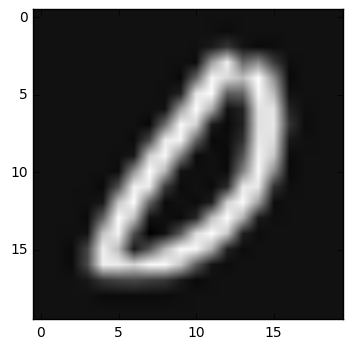

Neural Network Prediction =  0
Enter to continue or q to quit

Displaying Random Image


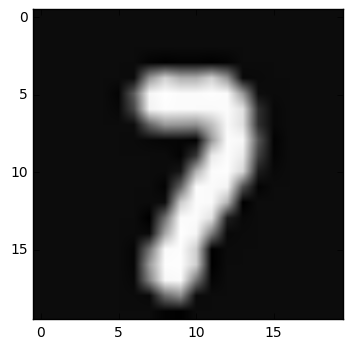

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


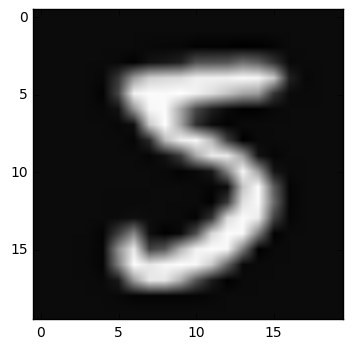

Neural Network Prediction =  [5]
Enter to continue or q to quit

Displaying Random Image


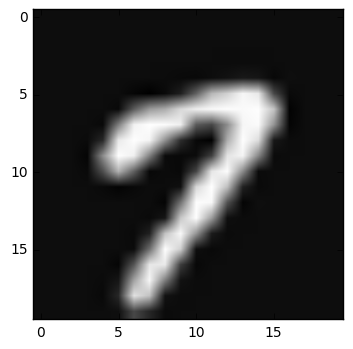

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


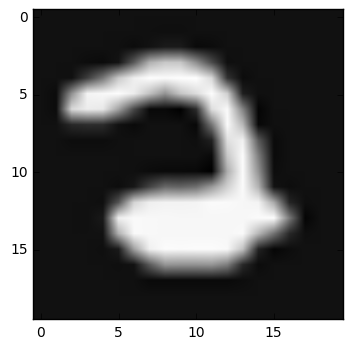


Neural Network Prediction =  [2]
Enter to continue or q to quit
Displaying Random Image


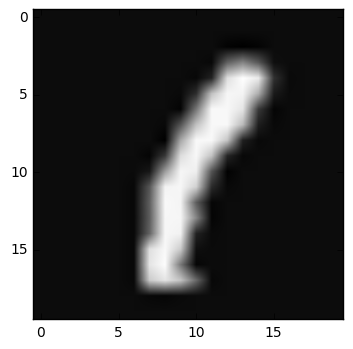

Neural Network Prediction =  [1]
Enter to continue or q to quit

Displaying Random Image


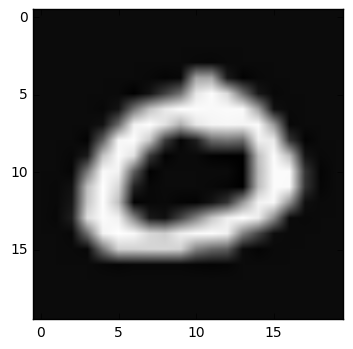

Neural Network Prediction =  0
Enter to continue or q to quit

Displaying Random Image


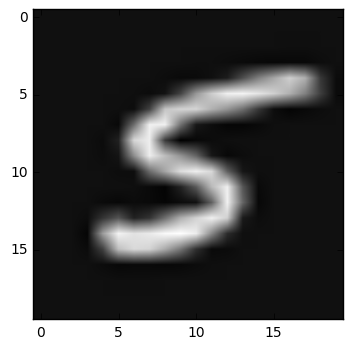

Neural Network Prediction =  [5]
Enter to continue or q to quit

Displaying Random Image


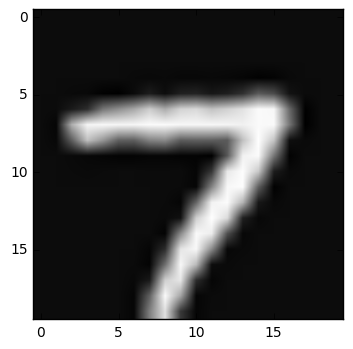

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


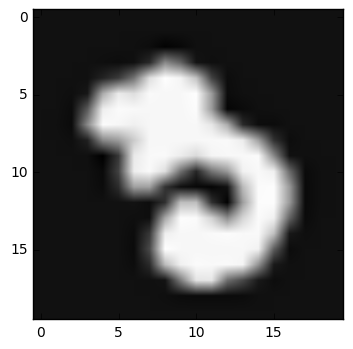

Neural Network Prediction =  [3]
Enter to continue or q to quit

Displaying Random Image


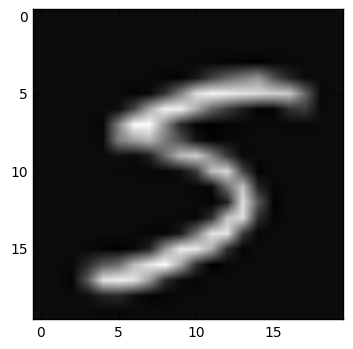

Neural Network Prediction =  [5]
Enter to continue or q to quit

Displaying Random Image


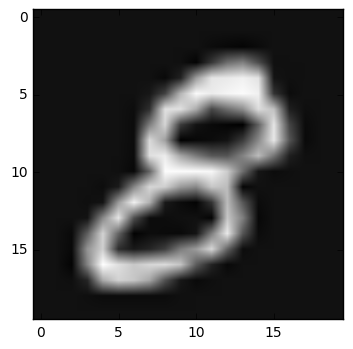

Neural Network Prediction =  [8]
Enter to continue or q to quit

Displaying Random Image


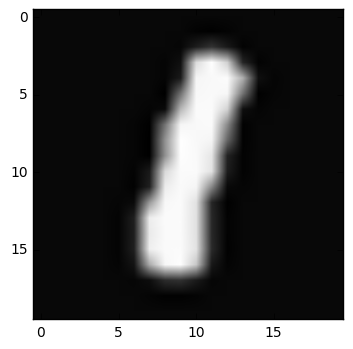

Neural Network Prediction =  [1]
Enter to continue or q to quit

Displaying Random Image


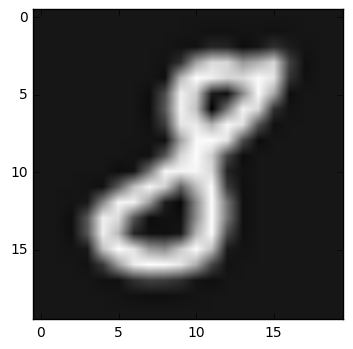

Neural Network Prediction =  [8]
Enter to continue or q to quit

Displaying Random Image


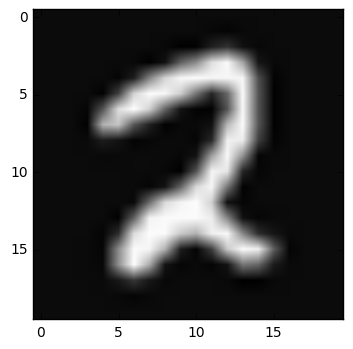

Neural Network Prediction =  [2]
Enter to continue or q to quit

Displaying Random Image


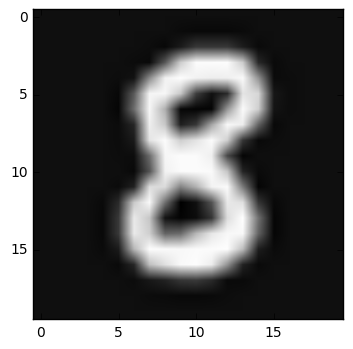

Neural Network Prediction =  [8]
Enter to continue or q to quit

Displaying Random Image


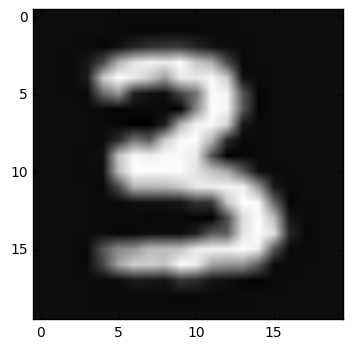

Neural Network Prediction =  [3]
Enter to continue or q to quit

Displaying Random Image


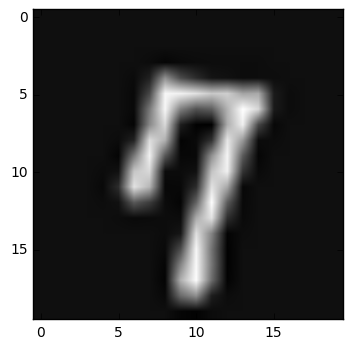

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


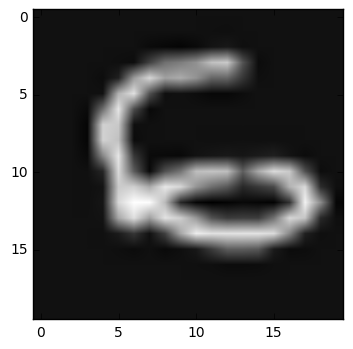

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


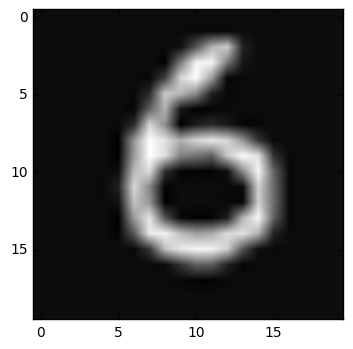

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


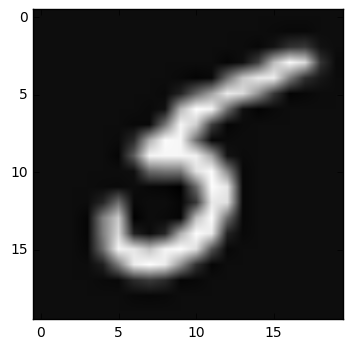

Neural Network Prediction =  [5]
Enter to continue or q to quit

Displaying Random Image


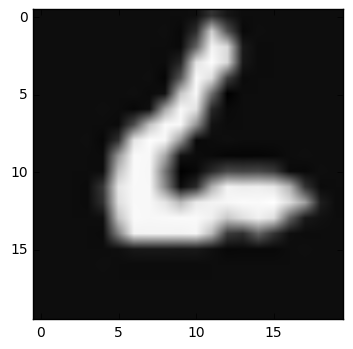

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


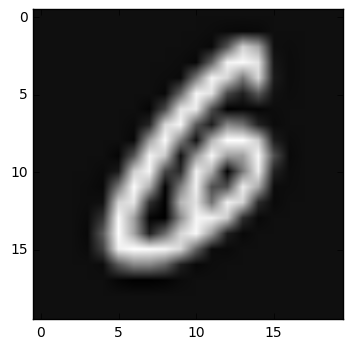

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


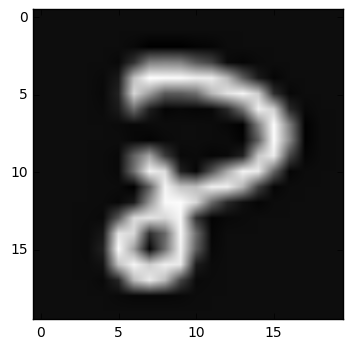


Neural Network Prediction =  [8]
Enter to continue or q to quit
Displaying Random Image


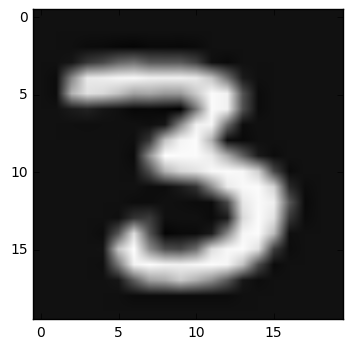

Neural Network Prediction =  [3]
Enter to continue or q to quit

Displaying Random Image


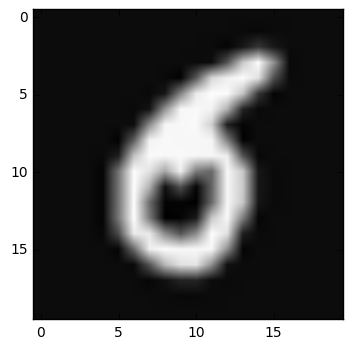

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


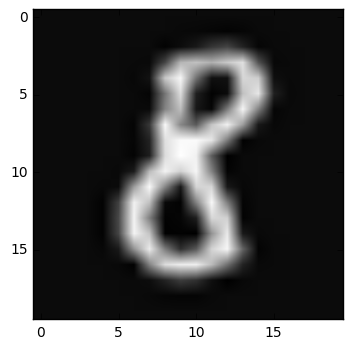

Neural Network Prediction =  [8]
Enter to continue or q to quit

Displaying Random Image


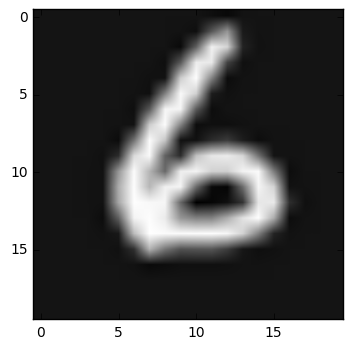

Neural Network Prediction =  [6]
Enter to continue or q to quit

Displaying Random Image


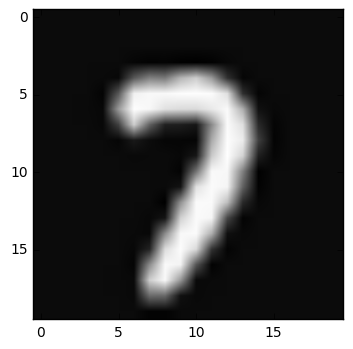

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


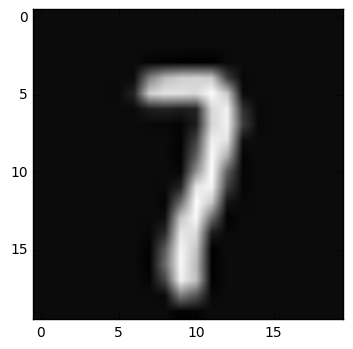

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


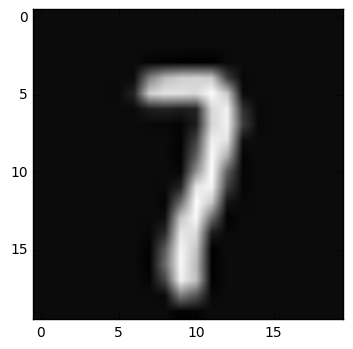

Neural Network Prediction =  [7]
Enter to continue or q to quit

Displaying Random Image


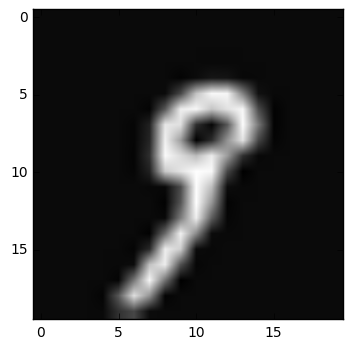

Neural Network Prediction =  [9]
Enter to continue or q to quit

Displaying Random Image


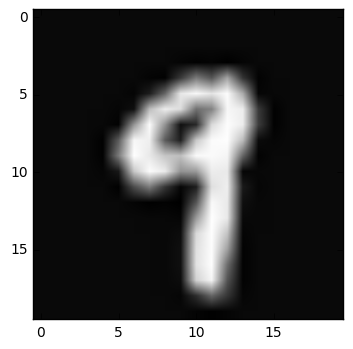

Neural Network Prediction =  [9]
Enter to continue or q to quit

Displaying Random Image


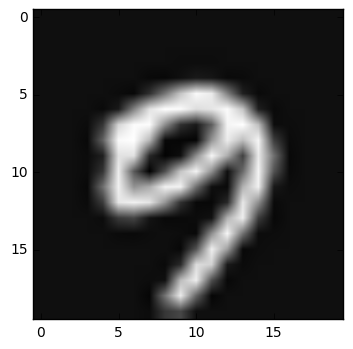

Neural Network Prediction =  [9]
Enter to continue or q to quit

Displaying Random Image


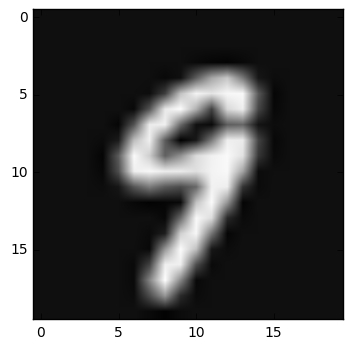

Neural Network Prediction =  [9]
Enter to continue or q to quit

Displaying Random Image


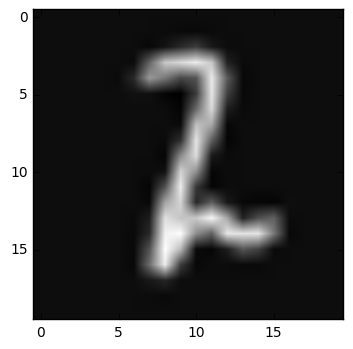

Neural Network Prediction =  [2]
Enter to continue or q to quit
q


In [11]:
# Test

for i in range(m):
    
    print ("Displaying Random Image")
    
    # Select a random image
    randomIndex = random.randint(a=1, b=m)
    img = getImage(X[randomIndex])
    plt.imshow(img,cmap = cm.Greys_r)
    plt.show()
    
    # Create a vector for the prediction
    shape = np.shape(X[randomIndex])
    imageVector = X[randomIndex]
    imageVector = imageVector.reshape((1, shape[0]))
    p = predict(T1, T2, imageVector)
    
    # Data treats 0's as 10's
    if p == 10:
        p = 0
    
    print ("Neural Network Prediction = ", p)
    print ("Enter to continue or q to quit")
    a = input()
    if a == "q":
        break